# Noisy electrodes

In the basic tutorial, we used electrodes that were ideal and noise free. However in experiments the recordings always tend to be noisy. This could be due to the limitation of the recording setup or other reasons. In this tutorial we will see how the kcsd estimation is affected due to noise level.
1. Reconstruction quality measure, starting from the basic functions tutorial  
2. Definition of a noise level added to the potentials
3. Error in the reconstruction with changing noise level

In [1]:
%matplotlib inline
import numpy as np
from scipy.integrate import simps
from kcsd import csd_profile as CSD
from kcsd import KCSD2D

# Step 1 - define a region of interest
csd_at = np.mgrid[0.:1.:100j,                                                                                                                                                           
                  0.:1.:100j]
csd_x, csd_y = csd_at

# Step 2 - test current sources as True CSD
CSD_PROFILE = CSD.gauss_2d_small
true_csd = CSD_PROFILE(csd_at, seed=15)

# Step 3 - location of electrodes
ele_x, ele_y = np.mgrid[0.05: 0.95: 10j,
                        0.05: 0.95: 10j]
ele_pos = np.vstack((ele_x.flatten(), ele_y.flatten())).T

# Step 4 - Computing the potentials at these electrode positions
def integrate_2d(csd_at, true_csd, ele_pos, h, csd_lims):
    csd_x, csd_y = csd_at
    xlin = csd_lims[0]                                                                                                                                                                                      
    ylin = csd_lims[1]                                                                                                                                                                                      
    Ny = ylin.shape[0]                                                                                                                                                                                      
    m = np.sqrt((ele_pos[0] - csd_x)**2 + (ele_pos[1] - csd_y)**2)                                                                                                           
    m[m < 0.0000001] = 0.0000001
    y = np.arcsinh(2 * h / m) * true_csd
    integral_1D = np.zeros(Ny)                                        
    for i in range(Ny):                                                  
        integral_1D[i] = simps(y[:, i], ylin)
    integral = simps(integral_1D, xlin)
    return integral

pots = np.zeros(ele_pos.shape[0])
xlin = csd_at[0, :, 0]
ylin = csd_at[1, 0, :]
h = 50.  # distance between the electrode plane and the CSD plane
sigma = 1.0 # S/m
for ii in range(ele_pos.shape[0]):                                                                                                                                                                      
    pots[ii] = integrate_2d(csd_at, true_csd,                                                                                                                                                         
                            [ele_pos[ii][0], ele_pos[ii][1]], h,                                                                                                                                      
                            [xlin, ylin])
pots /= 2 * np.pi * sigma
pots = pots.reshape((len(ele_pos), 1)) # first time point

# Step 5,6 KCSD computation with cross validation
def do_kcsd(ele_pos, pots_new):
    k = KCSD2D(ele_pos, pots_new, h=h, sigma=sigma,                                                                                                                                                       
               xmin=0.0, xmax=1.0,
               ymin=0.0, ymax=1.0,
               n_src_init=1000, src_type='gauss', R_init=1.)
    k.cross_validate(Rs=np.linspace(0.01, 0.15, 15))
    #k.cross_validate(Rs=np.array((0.11)).reshape(1, 1))
    return k

### Gist of basic features tutorial
We can use the code from the previous tutorial and start by defining most of the functionality from there. In this tutorial, we place the kcsd computation using the `KCSD2D` class inside a function called `do_kcsd` which we shall use subsequently.

In [2]:
def point_errors(true_csd, est_csd):
    nrm_est = est_csd.reshape(est_csd.size, 1) / np.max(np.abs(est_csd))
    nrm_csd = true_csd.reshape(true_csd.size, 1) / np.max(np.abs(true_csd))
    err = np.linalg.norm(nrm_csd - nrm_est, axis=1).reshape(true_csd.shape)
    return err

k_ideal = do_kcsd(ele_pos, pots)
estm_csd_ideal = k_ideal.values('CSD')
error_ideal = point_errors(true_csd, estm_csd_ideal)

No lambda given, using defaults
Cross validating R (all lambda) : 0.01
Cross validating R (all lambda) : 0.02
Cross validating R (all lambda) : 0.03
Cross validating R (all lambda) : 0.04
Cross validating R (all lambda) : 0.05
Cross validating R (all lambda) : 0.06
Cross validating R (all lambda) : 0.07
Cross validating R (all lambda) : 0.08
Cross validating R (all lambda) : 0.09
Cross validating R (all lambda) : 0.1
Cross validating R (all lambda) : 0.11
Cross validating R (all lambda) : 0.12
Cross validating R (all lambda) : 0.13
Cross validating R (all lambda) : 0.14
Cross validating R (all lambda) : 0.15
R, lambda : 0.11 1.46779926762e-06


### 1. Reconstruction quality measure
In order to assess the estimation quality we can measure the point wise difference between the true sources and the reconstructed sources from the kcsd. We define a function `point_errors` which takes the true_csd and the estimated_csd as the inputs, normalizes them individually, and computes the Frobenius norm of their difference.
***
We can then use the plotting function as we did earlier, except we will use greyscale colormap to display the intensity of the reconstruction error. And just as before, for the sake of convenience we shall define the plotting as a function called `make_error_plot`. 

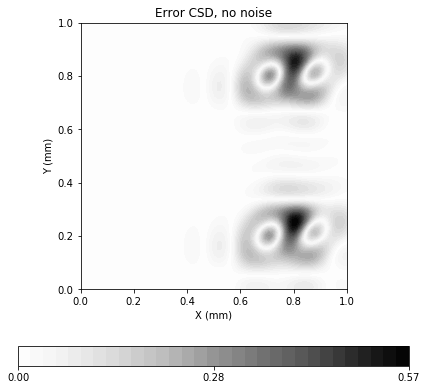

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def make_error_plot(xx, yy, error, title='Error CSD'):
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(111)
    ax.set_aspect('equal')
    t_max = np.max(np.abs(error))
    levels = np.linspace(0, t_max, 32)
    im = ax.contourf(xx, yy, error, levels=levels, cmap=cm.Greys)
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_title(title)
    ticks = np.linspace(0, t_max, 3, endpoint=True)
    plt.colorbar(im, orientation='horizontal', format='%.2f', ticks=ticks)
    return ax
    
make_error_plot(k_ideal.estm_x, k_ideal.estm_y, error_ideal, title='Error CSD, no noise')

In [4]:
def add_noise(pots, noise_level=0, noise_seed=23):
    rstate = np.random.RandomState(noise_seed) # So that its same every time
    noise = noise_level*0.01*rstate.normal(np.mean(pots), np.std(pots), size=(len(pots), 1))
    return pots + noise

### 2. Noise definition
We would like to add some noise to the exisiting recorded potenials, but at the same time we would like to be able to consistently look at the same noise when we inspect the reconstruction later. We define the noise as a normal distribution with the mean and standard devision same as the recorded potentials. Writing this as function called `add_noise` enables us to reuse it.

No lambda given, using defaults
Cross validating R (all lambda) : 0.01
Cross validating R (all lambda) : 0.02
Cross validating R (all lambda) : 0.03
Cross validating R (all lambda) : 0.04
Cross validating R (all lambda) : 0.05
Cross validating R (all lambda) : 0.06
Cross validating R (all lambda) : 0.07
Cross validating R (all lambda) : 0.08
Cross validating R (all lambda) : 0.09
Cross validating R (all lambda) : 0.1
Cross validating R (all lambda) : 0.11
Cross validating R (all lambda) : 0.12
Cross validating R (all lambda) : 0.13
Cross validating R (all lambda) : 0.14
Cross validating R (all lambda) : 0.15
R, lambda : 0.01 0.00110069417125


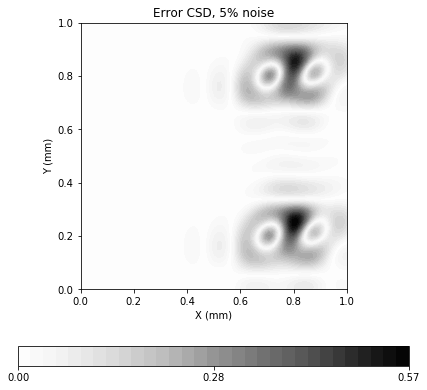

In [6]:
pots_noise = add_noise(pots, noise_level=15, noise_seed=23)
k_noise = do_kcsd(ele_pos, pots_noise)
estm_csd_noise = k_ideal.values('CSD')
error_noise = point_errors(true_csd, estm_csd_noise)

### 3. Reconstruction with noise
Lets, put this tutorial together, obtain the noise for a given noise level (choose between 0 and 100), and then use the obtained potentials to perform the CSD estimation. We can then use the error plots to compare the reconstruction  with the True CSD. Notice that the ideal parameters obtained after addtion of the noise need not be same the the one obtained when the potentials are without any noise addition.
***
We can display this error again with the plotting function which we defined earlier. Changing the `noise_level` and the `noise_seed` would change the reconstruction output. Also changing the True CSD type to a `gauss_2d_large` or changing `csd_seed`. So, the reconstruction errors depend on the location, type of the sources and the noises being added, which is expected and is mitigated by the crossvalidation.

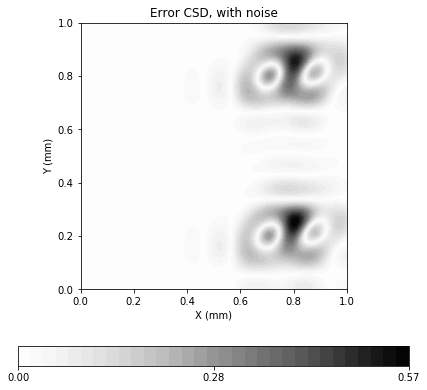

In [8]:
make_error_plot(k_noise.estm_x, k_noise.estm_y, error_noise, title='Error CSD, with noise')